# Lab 17: VEGAS Tutorial

In this lab, we will learn how to use the VEGAS algorithm to estimate the integral of a function. VEGAS is a Monte Carlo algorithm that uses importance sampling to estimate the integral of a function. The algorithm is particularly useful for high-dimensional integrals, where traditional methods such as the trapezoidal rule or Simpson's rule become impractical.

We will attempt to produce 100,000 events of the following function composed of two Gaussian distributions:

$$f(x, y) = A_1 \exp\left [-\frac{1}{2} \left ( \frac{(x - \mu_{1x})^2}{\sigma_{1x}^2} + \frac{(y - \mu_{1y})^2}{\sigma_{1y}^2} \right ) \right] + A_2 \exp\left [-\frac{1}{2} \left ( \frac{(x - \mu_{2x})^2}{\sigma_{2x}^2} + \frac{(y - \mu_{2y})^2}{\sigma_{2y}^2} \right ) \right]$$

over the range $0 < x, y < 5$. We will use the following parameters for the function:
$$A_1 = 1.0, \quad\mu_{1x} = 2.5, \quad\sigma_{1x} = 1.0, \quad\mu_{1y} = 2.5, \quad\sigma_{1y} = 1.0$$
$$A_2 = 4.0, \quad\mu_{2x} = 2.5, \quad\sigma_{2x} = 0.1, \quad\mu_{2y} = 2.5, \quad\sigma_{2y} = 0.1$$

References:
1. T. Barklow, "Monte Carlo Techniques", https://courses.physics.illinois.edu/phys524/fa2023/topics.html (2023).
2. G. P. Lepage, "A New Algorithm for Adaptive Multidimensional Integration", J. Comput. Phys. 27, 192 (1978).
3. G. P. Lepage, "Adaptive multidimensional integration: VEGAS enhanced", J. Comput. Phys. 439, 110386 (2021).

In [1]:
# import the required libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
cf = 3.894e+8 #pb per GeV^2
Mz = 91.188 # GeV --> Z boson mass
Gz = 2.4414 # GeV  --> Gamma_Z=Z boson width
alpha= 1/132.507
Gf = 1.16639e+5 # GeV^-2
Wtheta = 0.222246 # Weinberg angle
kappa = np.sqrt(2)*Gf*(Mz**2)/(4*np.pi*alpha)

Qe = -1
Vmu= -0.5 + 2*Wtheta**2
Ve = -0.5 + 2*Wtheta**2
Amu= -0.5
Ae = -0.5

XMIN = 100
XMAX = 40000
YMIN = -1
YMAX = 1

In [3]:
def chi1(s):
    # s = np.array(s)
    num = kappa*s*(s-Mz**2)
    den = (s-Mz**2)**2 + (Gz**2)*(Mz**2)
    return num/den
def chi2(s):
    # s = np.array(s)
    num = (kappa**2)*(s**2)
    den = (s-Mz**2)**2 + (Gz**2)*(Mz**2)
    return num/den

def A0(s):
    # s = np.array(s)
    return Qe**2 - 2*Qe*Vmu*Ve*chi1(s) + (Amu**2 + Vmu**2)*(Ae**2 + Ve**2)*chi2(s)

def A1(s):
    # s = np.array(s)
    return - 4*Qe*Amu*Ae*chi1(s) + 8*Amu*Vmu*Ae*Ve*chi2(s)

def cross_section(s,cost):
    s = np.array(s)
    cost = np.array(cost)
    const = (alpha**2)/(4*s)
    return const*(A0(s)*(1+cost**2) + A1(s)*cost)

In [4]:
s=np.linspace(100,40000,10000)
cost=np.linspace(-1,1,1000)

# To find max value we initially did a nested for loop
# fvals=[]
# for si in s:
#     for costi in cost:
#         fvals.append(cross_section(si,costi))
# F_VAL_MAX = np.max(fvals)

# Then we tried looking at the smallest energies
# s2=np.linspace(100,500,1000)
# fvals=[]
# for si in s2:
#     for costi in cost:
#         fvals.append(cross_section(si,costi))
# F_VAL_MAX = np.max(fvals)

# But this maximum value was way below the maximum value for the nested for loop

# So we tried to find the maximum value around the resonance point at the Mass of the Z boson (squared)
fvals=[]
for costi in cost:
    fvals.append(cross_section(Mz**2,costi))
F_VAL_MAX = np.max(fvals)

In [5]:
print('maximum is: ' +str(round(F_VAL_MAX*1e-14,3))+'e+14')

maximum is: 3.297e+14


## Acceptance-rejection Method
Now, we define the standard acceptance-rejection method.

In [7]:
def brute_force(nPoints, seed=None):
    nFunctionEval = 0
    yy1_rej_method = []
    yy2_rej_method = []
    maxWeightEncounteredRej = -1.0e20
    generator = np.random.RandomState(seed=seed)
    while len(yy1_rej_method) < nPoints:
        rr = generator.uniform(size=3)
        yy1, yy2 = XMIN + rr[0] * (XMAX - XMIN), YMIN + rr[1] * (YMAX - YMIN)
        nFunctionEval += 1
        f_val = cross_section(yy1, yy2)
        if f_val > maxWeightEncounteredRej:
            maxWeightEncounteredRej = f_val
        if f_val > F_VAL_MAX:
            print(
                f" f_val={f_val} exceeds F_VAL_MAX={F_VAL_MAX}, program will now exit"
            )
            exit(99)
        if f_val / F_VAL_MAX > rr[2]:
            yy1_rej_method.append(yy1)
            yy2_rej_method.append(yy2)
    return {
        "yy1": yy1_rej_method,
        "yy2": yy2_rej_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncounteredRej,
    }

## Vegas Method

In [6]:
def setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=None):
    """
    Input:
        NN: Number of intervals in [XMIN, XMAX] or [YMIN, YMAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    # intitial intervals: uniform intervals between XMIN/YMIN and XMAX/YMAX
    xLow = XMIN + (XMAX - XMIN) / NN * np.arange(NN + 1)
    delx = np.ones(NN) * (XMAX - XMIN) / NN
    px = np.ones(NN) / (XMAX - XMIN)  # probability density in each interval
    yLow = YMIN + (YMAX - YMIN) / NN * np.arange(NN + 1)  # YMIN + (YMAX) / NN * np.arange(NN + 1) 
    dely = np.ones(NN) * (YMAX - YMIN) / NN
    py = np.ones(NN) / (YMAX - YMIN)

    generator = np.random.RandomState(seed=seed)
    for _ in range(nIterations):
        ixLow = generator.randint(0, NN, size=KK)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform(size=KK)
        iyLow = generator.randint(0, NN, size=KK)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform(size=KK)
        ff = cross_section(xx, yy)
        f2barx = np.array(
            [sum((ff[ixLow == i] / py[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / px[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)
        fbardelxSum = np.sum(fbarx * delx)
        fbardelySum = np.sum(fbary * dely)
        logArgx = fbarx * delx / fbardelxSum
        logArgy = fbary * dely / fbardelySum
        mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)
        xLowNew = [xLow[i] + np.arange(mmx[i]) * delx[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [yLow[i] + np.arange(mmy[i]) * dely[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)
        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)
        i = np.arange(NN)
        xLow[:-1] = xLowNew[i * nCombx]
        yLow[:-1] = yLowNew[i * nComby]
        delx = np.diff(xLow)
        dely = np.diff(yLow)
        px = 1.0 / delx / NN
        py = 1.0 / dely / NN

    return xLow, yLow, delx, dely

In [7]:
xLow, yLow, delx, dely = setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=None)

In [251]:
def vegas(
    nPoints,
    vegasRatioFactor,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    errs=0
    xLow, yLow, delx, dely = setup_intervals(NN, KK, nIterations, alpha_damp, seed)
    # vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * delx[NN - 2] * dely[NN - 2]  # --> the previus problem seems to be taking the second/third/forth largest delx
    vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * np.min(delx) * np.min(dely)
    # vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * np.max(delx) * np.max(dely)
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = cross_section(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            errs+=1
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit. Error number {errs}"
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

In [20]:
def vegas2(
    nPoints,
    vegasRatioFactor,
    xLow,
    yLow,
    delx,
    dely,
    NN=100,
    seed=None,
):
    errs=0 # added error counter 
    # vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * delx[NN - 2] * dely[NN - 2]  # --> the previus problem seems to be taking the second largest delx
    vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * np.max(delx) * np.max(dely)
    print(vegasRatioMax)
    # vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * np.min(delx) * np.min(dely)
    # print(vegasRatioMax)
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed) #random number between 0-1
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN) # random integer between 0-NN (which is the length of delx)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN) # random integer between 0-NN (which is the length of dely)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = cross_section(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            errs+=1 # plus 1 to the counter
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit. Error number {errs}"
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

Run both algorithms and compare results

In [ ]:
# def plot_results(
#     nPoints,
#     vegasRatioFactor,
#     nBins=50,
#     NN=100,
#     KK=2000,
#     nIterations=4000,
#     alpha_damp=1.5,
#     seed=None,
# ):
#     bf = brute_force(nPoints, seed)
#     vg = vegas(nPoints, vegasRatioFactor, NN, KK, nIterations, alpha_damp, seed)
#     # brute force
#     titleRej = r"Acceptance-rejection Method $f(x,y)$"
#     lego_plot(bf["yy1"], bf["yy2"], nBins, "$x$", "$y$", titleRej)
#     plt.show()

#     # Vegas method
#     titleVrho = r"Vegas Method $p(x,y)$"
#     lego_plot(vg["yy1vrho"], vg["yy2vrho"], nBins, "$x$", "$y$", titleVrho)
#     plt.show()

#     titleVegas = r"Vegas Method $f(x,y)$"
#     lego_plot(vg["yy1vegas"], vg["yy2vegas"], nBins, "$x$", "$y$", titleVegas)
#     plt.show()

#     print(
#         f"Acceptance-rejection method nPoints={nPoints}, nFunctionEval={bf['nFunEval']}, maxWeightEncounteredRej={bf['maxWeightEncountered']}, F_VAL_MAX={F_VAL_MAX}"
#     )
#     print(
#         f"Vegas method nPoints={nPoints}, nFunctionEval={vg['nFunEval']}, maxWeightEncountered={vg['maxWeightEncountered']}, vegasRatioMax={vg['vegasRatioMax']}, vegasRatioFactor={vegasRatioFactor}"
#     )

This lego plot will show the function we are trying to integrate.

In [13]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title):
    x = np.array(xAmplitudes)  # turn x,y data into numpy arrays
    y = np.array(yAmplitudes)  # useful for regular matplotlib arrays

    fig = plt.figure()  # create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection="3d")

    # make histograms - set bins
    hist, xedges, yedges = np.histogram2d(x, y, bins=(nBins, nBins))
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])

    xpos = xpos.flatten() / 2.0
    ypos = ypos.flatten() / 2.0
    zpos = np.zeros_like(xpos)

    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    # cmap = mpl.colormaps.jet
    cmap = mpl.colormaps["jet"]
    max_height = np.max(dz)  # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k - min_height) / max_height) for k in dz]

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort="average")
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xlim(XMIN, XMAX)
    plt.ylim(YMIN, YMAX)
    plt.show()

In [34]:
# nPoints=10000
nPoints=10000
vegasRatioFactor=0.0001
vg = vegas2(nPoints, vegasRatioFactor, xLow,yLow,delx,dely)

1.838784702366052e+18


TO DO

Plot also 2D version:

f(x,y) vs x

f(x,y) vs y

Axes are flipped

vegas Compton NN-2

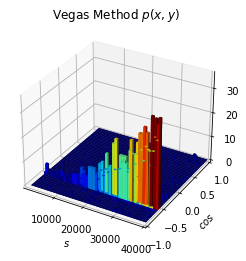

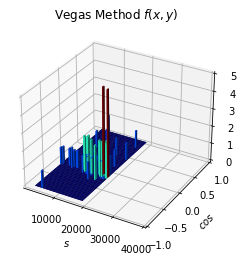

Vegas method nPoints=100, nFunctionEval=1331, maxWeightEncountered=6.474811425424408e+17, vegasRatioMax=1.838784702366052e+18, vegasRatioFactor=0.0001


In [33]:
nBins=50
# Vegas method
titleVrho = r"Vegas Method $p(x,y)$"
lego_plot(vg["yy1vrho"], vg["yy2vrho"], nBins, "$s$", "$cos$", titleVrho)

titleVegas = r"Vegas Method $f(x,y)$"
lego_plot(vg["yy1vegas"], vg["yy2vegas"], nBins, "$s$", "$cos$", titleVegas)

print(
    f"Vegas method nPoints={nPoints}, nFunctionEval={vg['nFunEval']}, maxWeightEncountered={vg['maxWeightEncountered']}, vegasRatioMax={vg['vegasRatioMax']}, vegasRatioFactor={vegasRatioFactor}"
)

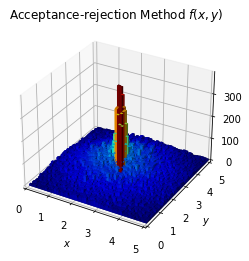

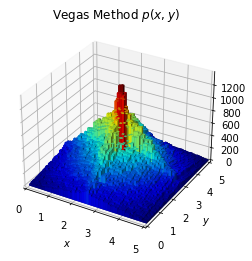

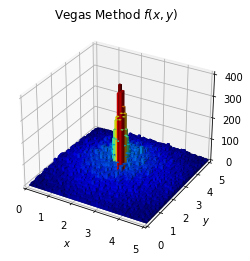

Acceptance-rejection method nPoints=100000, nFunctionEval=1118561, maxWeightEncounteredRej=4.9998616268769736, F_VAL_MAX=5.0
Vegas method nPoints=100000, nFunctionEval=689959, maxWeightEncountered=43.93508707489806, vegasRatioMax=77.2152674689456, vegasRatioFactor=0.1


In [7]:
plot_results(100_000, 0.1)